# Graph Knowledge Validation

This notebook evaluates the performance of the knowledge graph entity classification system against manually validated gold labels. We'll calculate accuracy metrics, generate confusion matrices, identify error patterns, and analyze confidence calibration to understand where the system succeeds and where it needs improvement.

## Step 1: Setup and Load Libraries

Import required libraries for data analysis and visualization. Configure visual settings for matplotlib and seaborn, and set up file paths to access the gold labels and system predictions.

In [10]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Configure visual settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 8)

# File paths
GOLD_PATH = "../data/gold/gold_labels.jsonl"
SYSTEM_PATH = "../data/processed/nodes_validated.jsonl"  # Or nodes.jsonl if not using LLM validation

print("Libraries loaded successfully.")

Libraries loaded successfully.


## Step 2: Load and Merge Datasets

Load manually validated gold labels and system predictions from JSONL files. Merge both datasets on node ID to create an analysis dataset containing both ground truth and system predictions with confidence scores.

In [11]:
# 1. Load Gold Labels (Ground Truth)
gold_data = []
with open(GOLD_PATH, 'r', encoding='utf-8') as f:
    for line in f:
        gold_data.append(json.loads(line))
df_gold = pd.DataFrame(gold_data)
df_gold = df_gold[['id', 'gold_type', 'comments']]  # Select key columns only

# 2. Load System Predictions
system_data = []
with open(SYSTEM_PATH, 'r', encoding='utf-8') as f:
    for line in f:
        system_data.append(json.loads(line))
df_system = pd.DataFrame(system_data)
# Rename to avoid confusion
df_system = df_system[['id', 'type', 'confidence', 'reason']].rename(columns={'type': 'pred_type'})

# 3. Merge datasets
# Analyze only nodes that exist in both datasets
df_analysis = pd.merge(df_gold, df_system, on='id', how='inner')

print(f"Total manually validated nodes: {len(df_gold)}")
print(f"Total nodes available for analysis: {len(df_analysis)}")

df_analysis.head()

Total manually validated nodes: 200
Total nodes available for analysis: 200


,id,gold_type,comments,pred_type,confidence,reason
0,Meera Reed,Character,,Character,High,Score: 8
1,Sunfyre,Creature,,Creature,High (LLM),"Explicitly described as a 'dragon', which is a creature within the GoT universe."
2,Trident,Location,,Location,High (LLM),Explicitly described as one of the largest rivers on the continent of Westeros.
3,Salt Shore,Location,,Location,High (LLM),The entity is explicitly described as a castle in Dorne.
4,Ten Thousand Ships (book),Object,,Object,High (LLM),Explicitly identified as an in-universe 'book' that characters interact with.


## Step 3: Calculate Overall Accuracy Metrics

Compute the overall accuracy of the system and generate a detailed classification report showing precision, recall, and F1-score for each entity type.

In [12]:
# Calculate overall accuracy
acc = accuracy_score(df_analysis['gold_type'], df_analysis['pred_type'])

print(f"🏆 Overall Accuracy: {acc:.2%}")

# Detailed classification report by class
print("\n--- Classification Report ---")
print(classification_report(df_analysis['gold_type'], df_analysis['pred_type']))

🏆 Overall Accuracy: 94.50%

--- Classification Report ---
              precision    recall  f1-score   support

      Battle       0.90      1.00      0.95        18
   Character       0.95      1.00      0.97        19
    Creature       1.00      0.95      0.98        21
     Episode       1.00      0.71      0.83        28
       House       0.80      1.00      0.89        16
    Location       1.00      1.00      1.00        20
        Lore       0.90      0.95      0.92        19
      Object       0.90      1.00      0.95        18
Organization       1.00      1.00      1.00        20
    Religion       1.00      0.95      0.98        21

    accuracy                           0.94       200
   macro avg       0.94      0.96      0.95       200
weighted avg       0.95      0.94      0.94       200



## Step 4: Generate Confusion Matrix

Visualize the confusion matrix to identify which entity types are confused with each other and where the system makes most of its mistakes.

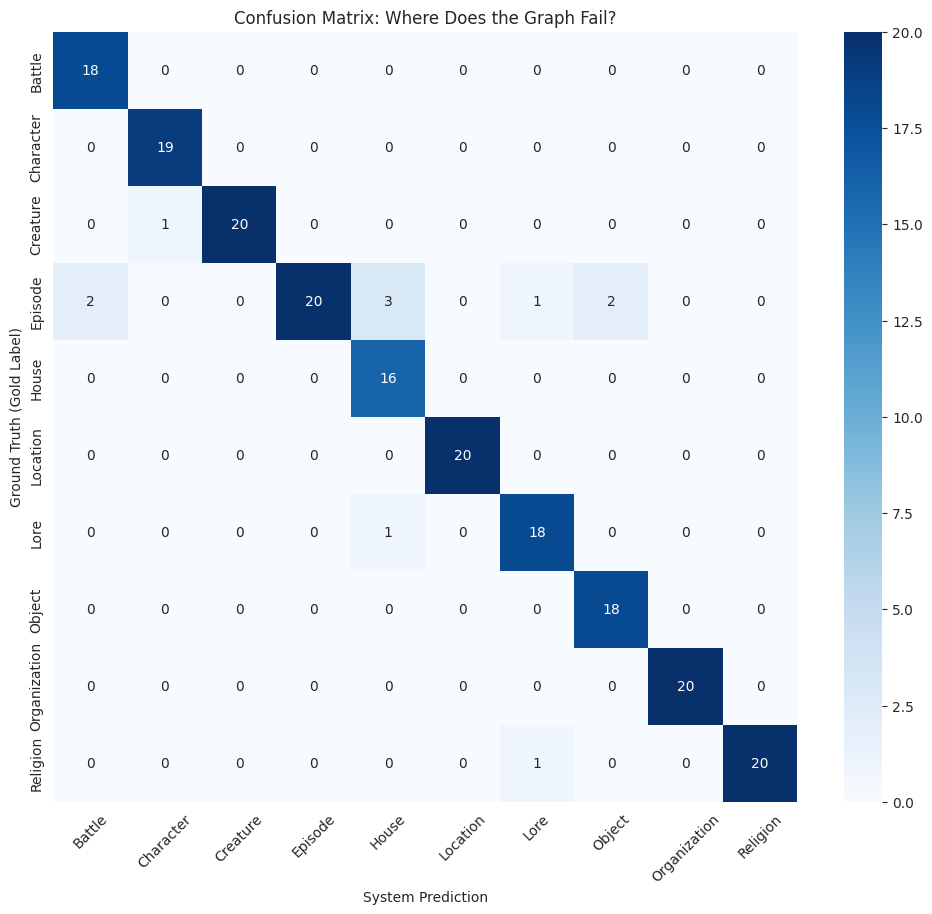

In [13]:
# Get sorted unique labels
labels = sorted(list(set(df_analysis['gold_type']) | set(df_analysis['pred_type'])))

cm = confusion_matrix(df_analysis['gold_type'], df_analysis['pred_type'], labels=labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('System Prediction')
plt.ylabel('Ground Truth (Gold Label)')
plt.title('Confusion Matrix: Where Does the Graph Fail?')
plt.xticks(rotation=45)
plt.show()

## Step 5: Analyze Classification Errors

Identify and examine all misclassified nodes. Display detailed information about errors including the predicted type, confidence score, system reasoning, and manual validation comments to understand failure patterns.

In [14]:
# Filter for misclassifications (where prediction does not match ground truth)
errors = df_analysis[df_analysis['gold_type'] != df_analysis['pred_type']]

print(f"Found {len(errors)} classification errors.")

# Display detailed error table
pd.set_option('display.max_colwidth', None)  # Show full text in columns

errors[['id', 'gold_type', 'pred_type', 'confidence', 'reason', 'comments']].sort_values(by='gold_type')

Found 11 classification errors.


,id,gold_type,pred_type,confidence,reason,comments
179,Ser Pounce,Creature,Character,High (LLM),"Ser Pounce is a named pet within the Game of Thrones universe, serving as a character.",
19,House Reed (short),Episode,House,High,Score: 10,
47,House Baelish (short),Episode,House,High,Score: 10,
77,"House Martell, Princes of Dorne",Episode,House,High,Score: 10,
85,Battle of the Bastards (short),Episode,Battle,Medium,Score: 6,
146,Invasion,Episode,Object,High (LLM),"This is the 'second chapter of Game of Thrones: Conquest & Rebellion: An Animated History', which is a segment of an animated documentary, classifying it as an object (media content).",
154,Inside HBOs Game of Thrones: Seasons 3 & 4,Episode,Object,High (LLM),"This entity is a 'companion book' (sequel) about the TV series, classifying it as a real-world object.",
161,Battle of Qohor (short),Episode,Battle,Medium,Score: 6,
194,The Nations of the North,Episode,Lore,High (LLM),"The text clearly identifies the entity as a 'short' in the 'Histories & Lore' series, categorizing it as 'Lore'.",
75,House of the Dragon: DracARys,Lore,House,High,Score: 10,


## Step 6: Evaluate Confidence Calibration

Analyze how well the system's confidence scores align with actual accuracy. Compare predicted confidence levels with real accuracy for each confidence group to determine if the model is well-calibrated.

     confidence  Real Accuracy  Count
0          High       0.888889     36
1    High (LLM)       0.962963    135
2        Medium       0.900000     20
3  Medium (LLM)       1.000000      9


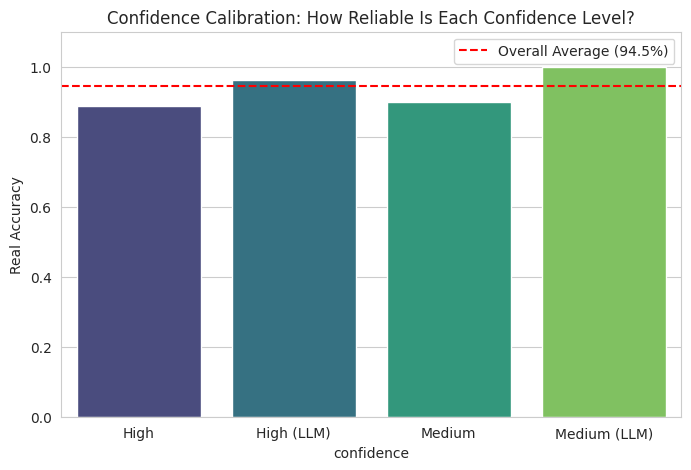

In [15]:
# 1. Calculate accuracy by confidence group
# FIX: Explicitly select [['gold_type', 'pred_type']]
# This prevents the 'confidence' column from being included in the lambda function, avoiding warnings.
confidence_analysis = df_analysis.groupby('confidence')[['gold_type', 'pred_type']].apply(
    lambda x: accuracy_score(x['gold_type'], x['pred_type'])
).reset_index(name='Real Accuracy')

# 2. Count number of cases per confidence level
confidence_counts = df_analysis['confidence'].value_counts().reset_index(name='Count')

# Rename column if necessary
if 'index' in confidence_counts.columns:
    confidence_counts = confidence_counts.rename(columns={'index': 'confidence'})

# 3. Merge results
stats = pd.merge(confidence_analysis, confidence_counts, on='confidence')
print(stats)

# 4. Plot calibration chart
plt.figure(figsize=(8, 5))
sns.barplot(
    data=stats, 
    x='confidence', 
    y='Real Accuracy', 
    palette='viridis',
    hue='confidence',  # Keep this for Seaborn styling
    legend=False
)

plt.ylim(0, 1.1)
plt.axhline(y=acc, color='r', linestyle='--', label=f'Overall Average ({acc:.1%})')
plt.title("Confidence Calibration: How Reliable Is Each Confidence Level?")
plt.legend()
plt.show()